In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
h5 = pd.HDFStore("/home/pchatha/mimic/data/all_hourly_data.h5")

In [4]:
h5.keys()

['/codes',
 '/interventions',
 '/patients',
 '/vitals_labs',
 '/vitals_labs_mean',
 '/patients/meta/values_block_6/meta',
 '/patients/meta/values_block_5/meta',
 '/patients/meta/values_block_4/meta',
 '/patients/meta/values_block_0/meta']

In [5]:
interventions = h5["interventions"].reset_index()

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#### Vitals!!

In [12]:
interventions = h5["interventions"].reset_index()
vent = interventions.groupby("subject_id")["vent"].any().astype(int)

### Get Lab Data

In [7]:
vitals = h5["vitals_labs_mean"].droplevel(['hadm_id', 'icustay_id'])
vitals.columns = vitals.columns.get_level_values(0)
vital_list = [
    'heart rate',
    'red blood cell count',
    'sodium',
    'mean blood pressure',
    'systemic vascular resistance',
    'glucose',
    'chloride urine',
    'glascow coma scale total',
    'hematocrit',
    'positive end-expiratory pressure set',
    'respiratory rate',
    'prothrombin time pt',
    'cholesterol',
    'hemoglobin',
    'creatinine',
    'blood urea nitrogen',
    'bicarbonate',
    'calcium ionized',
    'partial pressure of carbon dioxide',
    'magnesium',
    'anion gap',
    'phosphorous',
    'venous pvo2',
    'platelets',
    'calcium urine'
]

Confounding vitals: heart rate, hematocrit, platelets, hemoglobin

In [9]:
# vitals.notna().sum(0).sort_values().tail(30)

In [22]:
# vitals_sub = vitals[vital_list]

In [10]:
# vitals = vitals[vital_list]
vitals = vitals.fillna(method="ffill")
vitals = vitals.fillna(method="bfill")

In [11]:
mean = np.mean(vitals, axis=0)
std = np.std(vitals, axis=0)
vitals = (vitals - mean) / std

In [29]:
vitals.head()

LEVEL2               alanine aminotransferase   albumin  albumin ascites  \
subject_id hours_in                                                        
3          0                        -0.193043 -1.923109        -1.276641   
           1                        -0.193043 -1.923109        -1.276641   
           2                        -0.193043 -1.923109        -1.276641   
           3                        -0.193043 -1.923109        -1.276641   
           4                        -0.193043 -1.923109        -1.276641   

LEVEL2               albumin pleural  albumin urine  alkaline phosphate  \
subject_id hours_in                                                       
3          0                0.542858      -0.514431           -0.282113   
           1                0.542858      -0.514431           -0.282113   
           2                0.542858      -0.514431           -0.282113   
           3                0.542858      -0.514431           -0.282113   
           4                0.542858      -0.514431           -0.282113   

LEVEL2               anion gap  asparate aminotransferase  basophils  \
subject_id hours_in                                                    
3          0          2.058697                  -0.110791  -0.240575   
           1          2.058697                  -0.110791  -0.240575   
           2          2.058697                  -0.110791  -0.240575   
           3          2.058697                  -0.110791  -0.240575   
           4          2.058697                  -0.110791  -0.240575   

LEVEL2               bicarbonate  ...  total protein  total protein urine  \
subject_id hours_in               ...                                       
3          0            -1.85188  ...      -1.034424             0.364108   
           1            -1.85188  ...      -1.034424             0.364108   
           2            -1.85188  ...      -1.034424             0.364108   
           3            -1.85188  ...      -1.034424             0.364108   
           4            -1.85188  ...      -1.034424             0.364108   

LEVEL2               troponin-i  troponin-t  venous pvo2    weight  \
subject_id hours_in                                                  
3          0           1.439611   -0.372463    -1.136858  0.984624   
           1           1.439611   -0.372463    -1.136858  0.984624   
           2           1.439611   -0.372463    -1.136858  0.984624   
           3           1.439611   -0.372463    -1.136858  0.984624   
           4           1.439611   -0.372463    -1.136858  0.984624   

LEVEL2               white blood cell count  white blood cell count urine  \
subject_id hours_in                                                         
3          0                       0.358176                      0.112852   
           1                       0.358176                      0.112852   
           2                       0.358176                      0.112852   
           3                       0.358176                      0.112852   
           4                       0.358176                      0.112852   

LEVEL2                     ph  ph urine  
subject_id hours_in                      
3          0         0.068110 -0.855775  
           1         0.068110 -0.855775  
           2        -1.910089 -0.855775  
           3        -1.910089 -0.855775  
           4        -1.910089 -0.855775  

[5 rows x 104 columns]

In [14]:
vitals = vitals.join(vent, how="left")

In [22]:
last_avg = vitals.groupby(level=0).tail(4).groupby(level=0).mean()

In [26]:
diff = last_avg[last_avg["vent"]==1].mean() - last_avg[last_avg["vent"]==0].mean()

In [32]:
diff.sort_values().head(10)

oxygen saturation          -0.404630
hematocrit                 -0.360117
red blood cell count       -0.324113
hemoglobin                 -0.322449
diastolic blood pressure   -0.280926
mean blood pressure        -0.266058
systolic blood pressure    -0.263033
platelets                  -0.209581
glascow coma scale total   -0.157848
anion gap                  -0.123182
dtype: float64

In [33]:
diff.sort_values().tail(10)

phosphorous                                  0.080459
phosphate                                    0.084406
potassium                                    0.105248
bicarbonate                                  0.113084
mean corpuscular hemoglobin concentration    0.114247
magnesium                                    0.140170
temperature                                  0.141377
white blood cell count                       0.147733
weight                                       0.181907
vent                                         1.000000
dtype: float64

In [58]:
diff.loc["heart rate"]

0.054534623234064494

In [46]:
counts = h5["vitals_labs_mean"].droplevel(['hadm_id', 'icustay_id'])
counts.columns = counts.columns.get_level_values(0)
counts = counts.notna().sum()

In [51]:
top20 = counts.sort_values().tail(20).index

In [44]:
counts.sort_values().tail(20)

MultiIndex([(                       'bicarbonate', 'mean'),
            (               'blood urea nitrogen', 'mean'),
            (                        'creatinine', 'mean'),
            (                                'ph', 'mean'),
            (                        'hemoglobin', 'mean'),
            ('pulmonary artery pressure systolic', 'mean'),
            (                          'chloride', 'mean'),
            (                            'sodium', 'mean'),
            (                         'potassium', 'mean'),
            (                        'hematocrit', 'mean'),
            (          'glascow coma scale total', 'mean'),
            (           'central venous pressure', 'mean'),
            (                           'glucose', 'mean'),
            (                       'temperature', 'mean'),
            (                 'oxygen saturation', 'mean'),
            (               'mean blood pressure', 'mean'),
            (          'diastolic blood 

In [54]:
diff[top20].sort_values()

LEVEL2
oxygen saturation                    -0.404630
hematocrit                           -0.360117
hemoglobin                           -0.322449
diastolic blood pressure             -0.280926
mean blood pressure                  -0.266058
systolic blood pressure              -0.263033
glascow coma scale total             -0.157848
creatinine                           -0.058572
pulmonary artery pressure systolic   -0.032669
sodium                               -0.008314
blood urea nitrogen                   0.002235
chloride                              0.005704
central venous pressure               0.006820
respiratory rate                      0.031207
glucose                               0.046961
ph                                    0.052405
heart rate                            0.054535
potassium                             0.105248
bicarbonate                           0.113084
temperature                           0.141377
dtype: float64

In [31]:
vitals = vitals.join(stay_lengths, how="right")

Confounding vitals: heart rate, hematocrit, platelets, hemoglobin

<AxesSubplot:>

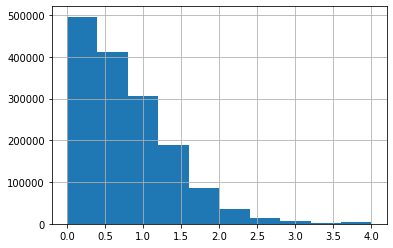

In [32]:
(np.abs(vitals["heart rate"])).clip(upper=4).hist()

#### visualize

In [51]:
vitals["heart rate"].head()

subject_id  hours_in
3           0           3.340470
            1           3.956230
            2           3.039750
            3           2.552869
            4           3.512310
Name: heart rate, dtype: float64

Int64Index([    3,     4,     6,     9,    11,    12,    13,    17,    18,
               19,
            ...
            99957, 99965, 99966, 99973, 99982, 99983, 99991, 99992, 99995,
            99999],
           dtype='int64', name='subject_id', length=34472)

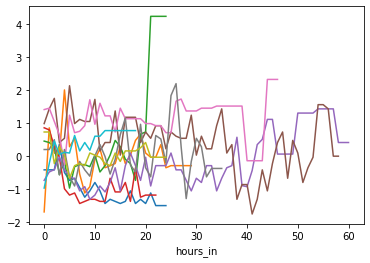

In [63]:
for i in np.random.choice(vitals.index.levels[0], 10):
    vitals["mean blood pressure"].loc[i].plot()

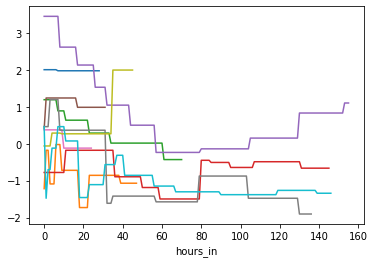

In [60]:
for i in np.random.choice(vitals.index.levels[0], 10):
    vitals["hematocrit"].loc[i].plot()

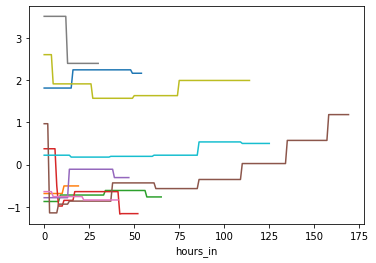

In [61]:
for i in np.random.choice(vitals.index.levels[0], 10):
    vitals["platelets"].loc[i].plot()

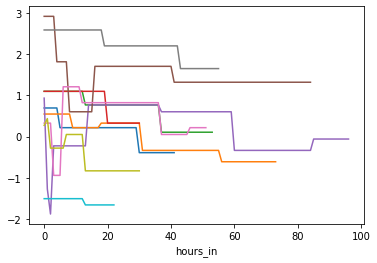

In [62]:
for i in np.random.choice(vitals.index.levels[0], 10):
    vitals["hemoglobin"].loc[i].plot()

<AxesSubplot:xlabel='hours_in'>

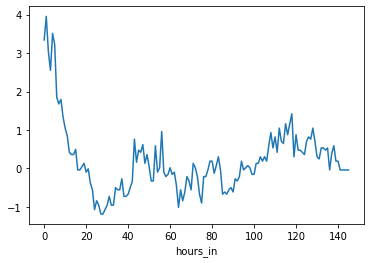

In [53]:
vitals["heart rate"].loc[3].plot()